# Triplet Loss with Faces -- Fairness Study

## Initialization

In [1]:
# !pip install torch

In [2]:
# !pip install mat73

In [3]:
# !pip install wandb -qqq
# import wandb

In [4]:
# !git clone https://github.com/mgornet/CNPEN

### Check device

In [5]:
!nvidia-smi

Tue Jun 21 14:56:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A400...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   60C    P8    21W /  N/A |     75MiB /  8192MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Librairies

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import perf_counter
from typing import Callable
import itertools
import mat73
import pandas as pd
import re

import sys
import os
import tarfile

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import os.path as op
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve
    
from sklearn.metrics import confusion_matrix, auc, roc_curve, \
precision_recall_curve, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from scipy import optimize

import wandb

In [2]:
%cd ./files/

from triplet import TripletGenerator, TripletLearner, TripletLoss, TripletLossRaw, \
distance, distance_vectors
from builder import create_dataframe, from_tensor_to_numpy, from_numpy_to_tensor, extend_dataframe
from prints import print_img, print_img_from_path, print_img_from_id, \
print_img_from_classid, print_from_gen, print_from_gen2, print_pair, print_hist_loss, \
print_hist_dist, print_hist_dist_zoom, print_img_category, \
print_roc, print_logistic_regression, print_prec_recall
from test_train_loops import training, testing, adaptative_train, compute_distances
from classification import authentification_img, predict, triplet_acc,\
build_df_fairness, triplet_acc_fairness, bootstrap, bootstrap_by_pairs #triplet_acc_for_bootstrap

/home/mgornet/Bureau/Code/CNPEN/files


In [3]:
!pwd

/home/mgornet/Bureau/Code/CNPEN/files


## Generate Data

### Create dataframe

In [4]:
URL = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
FILENAME = "lfw-deepfunneled.tgz"

if not op.exists(FILENAME):
    print('Downloading %s to %s...' % (URL, FILENAME))
    urlretrieve(URL, FILENAME)

if not op.exists("lfw"):
    print('Extracting image files...')
    tar = tarfile.open("lfw-deepfunneled.tgz")
    tar.extractall("lfw")
    tar.close()

In [5]:
PATH = "lfw/lfw-deepfunneled/"

In [6]:
tic = perf_counter()
df_init, all_imgs = create_dataframe()
toc = perf_counter()
print(f"DataFrame creation: {((toc - tic)/60):.1f} min")

Number of individuals:  5749
Number of total images:  13233
images weigh  0.57 GB
DataFrame creation: 0.8 min


In [7]:
tic = perf_counter()
df = extend_dataframe(df_init)
toc = perf_counter()
print(f"DataFrame extention: {((toc - tic)/60):.1f} min")

DataFrame extention: 0.1 min


### Build sets, generators and network

In [8]:
num_classes = len(df.Classid.unique())
print("Number of individuals: ", num_classes)

Number of individuals:  5749


In [9]:
indiv_min = df.Classid.min()
split_train_valid = int(num_classes * 0.75)
split_train_test = int(num_classes * 0.8)
indiv_max = df.Classid.max()

In [10]:
print(f"Train set from indiv {indiv_min} to {split_train_valid-1}")
print(f"Valid set from indiv {split_train_valid} to {split_train_test-1}")
print(f"Test set from indiv {split_train_test} to {indiv_max}")

Train set from indiv 0 to 4310
Valid set from indiv 4311 to 4598
Test set from indiv 4599 to 5748


In [11]:
df_train = df[df.Classid<split_train_valid]
df_valid = df[(df.Classid>=split_train_valid)&(df.Classid<split_train_test)]
df_test = df[df.Classid>=split_train_test]

In [12]:
print("Number of training images: ", len(df_train))
print("Number of validation images: ", len(df_valid))
print("Number of testing images: ", len(df_test))
print("Number of total images: ", len(df_train)+len(df_valid)+len(df_test))
print("len original: ", len(df))

Number of training images:  10060
Number of validation images:  586
Number of testing images:  2587
Number of total images:  13233
len original:  13233


In [13]:
print("Number of individuals in the training set: ", len(df_train.Classid.unique()))
print("Number of individuals in the validation set: ", len(df_valid.Classid.unique()))
print("Number of individuals in the testing set: ", len(df_test.Classid.unique()))

Number of individuals in the training set:  4311
Number of individuals in the validation set:  288
Number of individuals in the testing set:  1150


In [14]:
value_count = df_train.Classid.value_counts()
print("Number of individuals with more than one image in the training set: ", len(value_count[value_count.values>1]))
value_count = df_valid.Classid.value_counts()
print("Number of individuals with more than one image in the validation set: ", len(value_count[value_count.values>1]))
value_count = df_test.Classid.value_counts()
print("Number of individuals with more than one image in the testing set: ", len(value_count[value_count.values>1]))

Number of individuals with more than one image in the training set:  1267
Number of individuals with more than one image in the validation set:  79
Number of individuals with more than one image in the testing set:  334


In [15]:
df_valid.head()

,Classid,Name,Path,Male,Asian,White,Black,Baby,Child,Youth,...,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
10060,4311,Pedro_Solbes,Pedro_Solbes/Pedro_Solbes_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
10061,4311,Pedro_Solbes,Pedro_Solbes/Pedro_Solbes_0002.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
10062,4311,Pedro_Solbes,Pedro_Solbes/Pedro_Solbes_0003.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
10063,4311,Pedro_Solbes,Pedro_Solbes/Pedro_Solbes_0004.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10064,4312,Pedro_Velasquez,Pedro_Velasquez/Pedro_Velasquez_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
BATCH_SIZE = 128 # 128
BATCH_VALID_SIZE = 128 #128 #8
BATCH_TEST_SIZE = 128 #128 #32

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
margin = 0.2
criterion = TripletLoss(margin)
criterion_test = TripletLossRaw(margin)

### Load Model

In [18]:
# Load pretrained model

model = TripletLearner(base_channels=32)
model.load_state_dict(torch.load("../models/in_article/base_121_1000epochs.pth",map_location=torch.device('cpu')))
model = model.to(device)
model.eval()

TripletLearner(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

### Determine THRESHOLD

In [19]:
# Build THRESHOLD (for details, see the notebook "determine_threshold")

gen = TripletGenerator(df_valid, all_imgs, BATCH_VALID_SIZE, device, model, margin)
loader = DataLoader(gen, batch_size=None, shuffle=True)

list_loader = []
for _ in range(10):
    list_loader.extend(list(loader))

pos_dist, neg_dist, _ = compute_distances(list_loader, device, model) #loader

y_pos = [1 for _ in range(len(pos_dist))]
y_neg = [0 for _ in range(len(neg_dist))]

y = y_pos + y_neg
X = pos_dist + neg_dist
Xmoins = np.array(X)*(-1)
Xlogistic = np.array(Xmoins).reshape(-1,1)

clf = LogisticRegression(random_state=0).fit(Xlogistic, y)

THRESHOLD = (clf.intercept_/clf.coef_)[0,0]
print("THRESHOLD with logistic regression:", THRESHOLD)

/home/mgornet/Bureau/Code/CNPEN/files/triplet.py:243: UserWarning: Batch size number was changed from 128 to 79 because there are only 79 individuals with more than 2 pictures.
  warnings.warn(


Processing:   0%|          | 0/10 [00:00<?, ?it/s]

THRESHOLD with logistic regression: 0.8434252821227377


## Fairness study

### Build data fairness

In [20]:
gen = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model, margin, return_id=True)

/home/mgornet/Bureau/Code/CNPEN/files/triplet.py:253: UserWarning: Number of unique identities with more than 2 pictures (334) is not divisible by batch_size (128). Remainder: 78
  warnings.warn(


In [21]:
# tic = perf_counter()
# df_fairness = build_df_fairness(all_imgs, df_test, gen, 20, device, model, THRESHOLD)
# toc = perf_counter()
# print(f"DataFrame creation: {((toc - tic)/60):.1f} min")

In [22]:
tic = perf_counter()
df_fairness = build_df_fairness(all_imgs, df_test.append(df_valid), gen, 50, device, model, THRESHOLD)
toc = perf_counter()
print(f"DataFrame creation: {((toc - tic)/60):.1f} min")

/tmp/ipykernel_8142/3599316701.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_fairness = build_df_fairness(all_imgs, df_test.append(df_valid), gen, 50, device, model, THRESHOLD)


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

DataFrame creation: 0.2 min


In [23]:
df_fairness

,id_A,id_B,pair,y_true,y_pred,Distance,A_Male,B_Male,A_White,B_White,...,B_Youth,A_Senior,B_Senior,A_Sunglasses,B_Sunglasses,A_WhiteMale,B_WhiteMale,AB_WhiteMale,AB_NoWhiteMale,correct_predict
0,12904,12905,0,1,1,0.107341,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,11465,11472,1,1,1,0.648786,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,11221,11222,2,1,1,0.182725,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,11163,11164,3,1,1,0.424274,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
4,11396,11395,4,1,0,1.009260,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25595,11947,11283,12795,0,0,0.911174,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
25596,11280,12797,12796,0,0,1.696134,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
25597,12226,13084,12797,0,0,5.967003,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
25598,12391,13171,12798,0,0,2.154198,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0


In [24]:
df_fairness.describe()

,id_A,id_B,pair,y_true,y_pred,Distance,A_Male,B_Male,A_White,B_White,...,B_Youth,A_Senior,B_Senior,A_Sunglasses,B_Sunglasses,A_WhiteMale,B_WhiteMale,AB_WhiteMale,AB_NoWhiteMale,correct_predict
count,25600.000000,25600.000000,25600.000000,25600.00000,25600.000000,25600.000000,25448.000000,25417.000000,25448.000000,25417.000000,...,25417.000000,25448.000000,25417.000000,25448.000000,25417.000000,25448.000000,25417.000000,25265.000000,25600.000000,25600.000000
mean,11849.274766,11896.236641,6399.500000,0.50000,0.529609,1.131033,0.784345,0.797458,0.741434,0.727505,...,0.153008,0.192628,0.196089,0.015325,0.015856,0.597139,0.593068,0.432179,0.238594,0.864219
std,780.235180,766.518533,3695.113882,0.50001,0.499132,1.036759,0.411284,0.401902,0.437855,0.445252,...,0.360002,0.394371,0.397045,0.122846,0.124919,0.490483,0.491272,0.495389,0.426232,0.342563
min,10648.000000,10646.000000,0.000000,0.00000,0.000000,0.027625,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11175.000000,11233.000000,3199.750000,0.00000,0.000000,0.331635,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,11796.000000,11861.000000,6399.500000,0.50000,1.000000,0.772205,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,12586.000000,12593.250000,9599.250000,1.00000,1.000000,1.671437,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,13227.000000,13232.000000,12799.000000,1.00000,1.000000,7.614568,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
df_fairness.columns

Index(['id_A', 'id_B', 'pair', 'y_true', 'y_pred', 'Distance', 'A_Male',
       'B_Male', 'A_White', 'B_White', 'A_Black', 'B_Black', 'A_Asian',
       'B_Asian', 'A_Indian', 'B_Indian', 'A_Youth', 'B_Youth', 'A_Senior',
       'B_Senior', 'A_Sunglasses', 'B_Sunglasses', 'A_WhiteMale',
       'B_WhiteMale', 'AB_WhiteMale', 'AB_NoWhiteMale', 'correct_predict'],
      dtype='object')

### Look at general stats

In [26]:
print("Same identity - mean distance: ", df_fairness[df_fairness.y_true==1].Distance.mean())
print("Same identity - std distance: ", df_fairness[df_fairness.y_true==1].Distance.std())
print("Same identity - percentiles: ", np.percentile(df_fairness[df_fairness.y_true==1]['Distance'], [5,25,50,75,95]))
print("\n")
print("Different identities - mean distance: ", df_fairness[df_fairness.y_true==0].Distance.mean())
print("Different identities - std distance: ", df_fairness[df_fairness.y_true==0].Distance.std())
print("Different identities - percentiles: ", np.percentile(df_fairness[df_fairness.y_true==0]['Distance'], [5,25,50,75,95]))
print("\n")
print("Mean accuracy: ", df_fairness['correct_predict'].mean())
print("Bootstrapping mean accuracy: ", bootstrap(df_fairness, agg_func=lambda df: df['correct_predict'].mean()))
print("\n")
print("Triplet accuracy: ", triplet_acc_fairness(df_fairness))

Same identity - mean distance:  0.43424623576676824
Same identity - std distance:  0.33663226935497287
Same identity - percentiles:  [0.08516465 0.19575712 0.33920467 0.57446682 1.09403749]


Different identities - mean distance:  1.8278194101000553
Different identities - std distance:  1.0321831341137941
Different identities - percentiles:  [0.47380317 1.05267483 1.64978254 2.42064834 3.79145105]


Mean accuracy:  0.86421875
Bootstrapping mean accuracy:  [0.86082031 0.86277344 0.86417969 0.86571289 0.86766016]


Triplet accuracy:  0.93921875


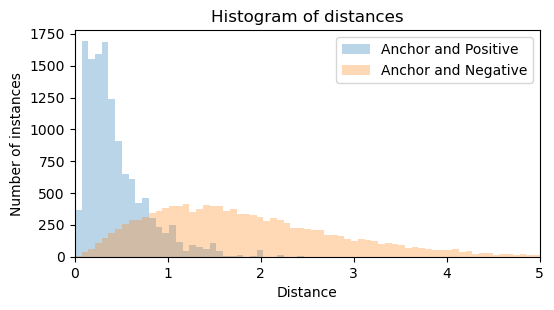

In [27]:
pos_dist = df_fairness[df_fairness.y_true==1]['Distance']
neg_dist = df_fairness[df_fairness.y_true==0]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

In [28]:
X = -np.array(df_fairness.Distance)
y = np.array(df_fairness.y_true)
y_pred = np.array(df_fairness.y_pred)

In [29]:
fpr_dist, tpr_dist, thresholds_dist = roc_curve(y, X)
roc_auc_dist = auc(fpr_dist,tpr_dist)

precision_dist, recall_dist, thresholds_recall_dist = precision_recall_curve(y, X)
auc_s_dist = auc(recall_dist, precision_dist)

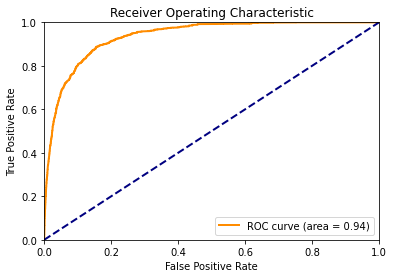

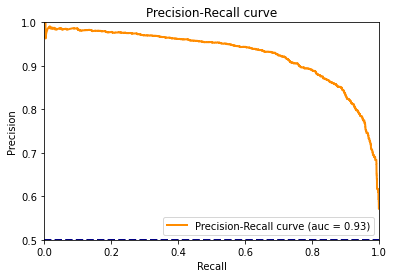

In [30]:
print_roc(fpr_dist, tpr_dist, roc_auc_dist)
print_prec_recall(precision_dist, recall_dist, auc_s_dist)

In [31]:
tn,fp,fn,tp = confusion_matrix(y, y_pred).ravel()

TPR = tp/(tp+fp)
FPR = fp/(tp+fp)
TNR = tn/(tn+fn)
FNR = fn/(tn+fn)

In [32]:
print("Confusion Matrix Total")
print(confusion_matrix(y, y_pred))

print("\n","Accuracy score:",accuracy_score(y, y_pred))
 
print("\n", "f1 score:", f1_score(y, y_pred), "\n")

print('TPR: ', TPR)
print('FPR: ', FPR)
print('TNR: ', TNR)
print('FNR: ', FNR)

Confusion Matrix Total
[[10683  2117]
 [ 1359 11441]]

 Accuracy score: 0.86421875

 f1 score: 0.8681235298581076 

TPR:  0.8438560259625314
FPR:  0.15614397403746866
TNR:  0.8871449925261584
FNR:  0.11285500747384156


### Stats in subgroups

#### White Male vs Non White Male

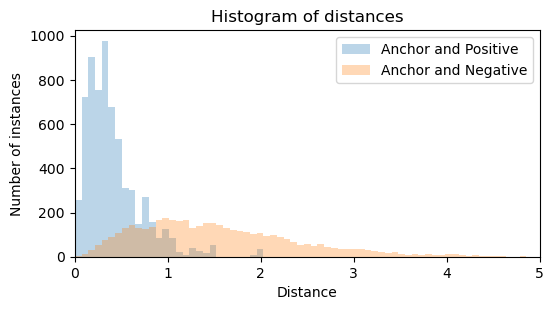

In [33]:
pos_dist = df_fairness[(df_fairness.y_true==1) & (df_fairness.AB_WhiteMale==1)]['Distance']
neg_dist = df_fairness[(df_fairness.y_true==0) & (df_fairness.AB_WhiteMale==1)]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

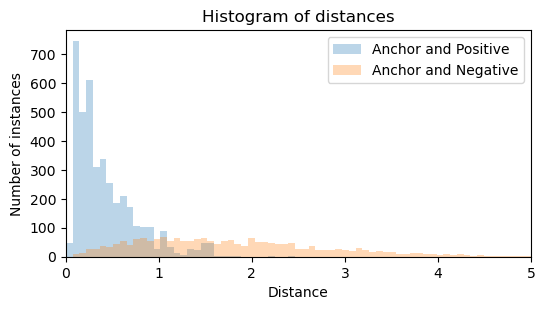

In [34]:
pos_dist = df_fairness[(df_fairness.y_true==1) & (df_fairness.AB_NoWhiteMale==1)]['Distance']
neg_dist = df_fairness[(df_fairness.y_true==0) & (df_fairness.AB_NoWhiteMale==1)]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

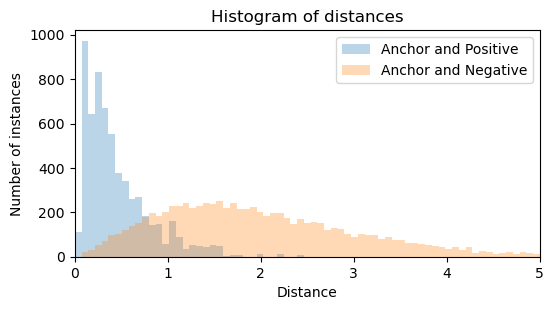

In [35]:
pos_dist = df_fairness[(df_fairness.y_true==1) & (df_fairness.AB_WhiteMale==0)]['Distance']
neg_dist = df_fairness[(df_fairness.y_true==0) & (df_fairness.AB_WhiteMale==0)]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

In [36]:
y_AB_WhiteMale = np.array(df_fairness[df_fairness['AB_WhiteMale']==1].y_true)
y_pred_AB_WhiteMale = np.array(df_fairness[df_fairness['AB_WhiteMale']==1].y_pred)

tn_AB_WhiteMale,fp_AB_WhiteMale,fn_AB_WhiteMale,tp_AB_WhiteMale = confusion_matrix(y_AB_WhiteMale, y_pred_AB_WhiteMale).ravel()

TPR_AB_WhiteMale = tp_AB_WhiteMale/(tp_AB_WhiteMale+fp_AB_WhiteMale)
FPR_AB_WhiteMale = fp_AB_WhiteMale/(tp_AB_WhiteMale+fp_AB_WhiteMale)
TNR_AB_WhiteMale = tn_AB_WhiteMale/(tn_AB_WhiteMale+fn_AB_WhiteMale)
FNR_AB_WhiteMale = fn_AB_WhiteMale/(tn_AB_WhiteMale+fn_AB_WhiteMale)

y_AB_NoWhiteMale = np.array(df_fairness[df_fairness['AB_NoWhiteMale']==1].y_true)
y_pred_AB_NoWhiteMale = np.array(df_fairness[df_fairness['AB_NoWhiteMale']==1].y_pred)

tn_AB_NoWhiteMale,fp_AB_NoWhiteMale,fn_AB_NoWhiteMale,tp_AB_NoWhiteMale = confusion_matrix(y_AB_NoWhiteMale, y_pred_AB_NoWhiteMale).ravel()

TPR_AB_NoWhiteMale = tp_AB_NoWhiteMale/(tp_AB_NoWhiteMale+fp_AB_NoWhiteMale)
FPR_AB_NoWhiteMale = fp_AB_NoWhiteMale/(tp_AB_NoWhiteMale+fp_AB_NoWhiteMale)
TNR_AB_NoWhiteMale = tn_AB_NoWhiteMale/(tn_AB_NoWhiteMale+fn_AB_NoWhiteMale)
FNR_AB_NoWhiteMale = fn_AB_NoWhiteMale/(tn_AB_NoWhiteMale+fn_AB_NoWhiteMale)

y_AoB_NoWhiteMale = np.array(df_fairness[df_fairness['AB_WhiteMale']==0].y_true)
y_pred_AoB_NoWhiteMale = np.array(df_fairness[df_fairness['AB_WhiteMale']==0].y_pred)

tn_AoB_NoWhiteMale,fp_AoB_NoWhiteMale,fn_AoB_NoWhiteMale,tp_AoB_NoWhiteMale = confusion_matrix(y_AoB_NoWhiteMale, y_pred_AoB_NoWhiteMale).ravel()

TPR_AoB_NoWhiteMale = tp_AoB_NoWhiteMale/(tp_AoB_NoWhiteMale+fp_AoB_NoWhiteMale)
FPR_AoB_NoWhiteMale = fp_AoB_NoWhiteMale/(tp_AoB_NoWhiteMale+fp_AoB_NoWhiteMale)
TNR_AoB_NoWhiteMale = tn_AoB_NoWhiteMale/(tn_AoB_NoWhiteMale+fn_AoB_NoWhiteMale)
FNR_AoB_NoWhiteMale = fn_AoB_NoWhiteMale/(tn_AoB_NoWhiteMale+fn_AoB_NoWhiteMale)

In [37]:
print("A and B White Male - mean accuracy: ", df_fairness[df_fairness['AB_WhiteMale']==1]['correct_predict'].mean())
print("A and B White Male - bootstrapping mean accuracy: ", bootstrap(df_fairness[df_fairness['AB_WhiteMale']==1], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B White Male - triplet accuracy: ", triplet_acc_fairness(df_fairness[df_fairness['AB_WhiteMale']==1]))
print("A and B White Male - f1 score:", f1_score(y_AB_WhiteMale, y_pred_AB_WhiteMale))
print("\n")
print("A and B Non White Male - mean accuracy: ", df_fairness[df_fairness['AB_NoWhiteMale']==1]['correct_predict'].mean())
print("A and B Non White Male - bootstrapping mean accuracy: ", bootstrap(df_fairness[df_fairness['AB_NoWhiteMale']==1], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Non White Male - triplet accuracy: ", triplet_acc_fairness(df_fairness[df_fairness['AB_NoWhiteMale']==1]))
print("A and B Non White Male - f1 score:", f1_score(y_AB_NoWhiteMale, y_pred_AB_NoWhiteMale))
print("\n")
print("A or B Non White Male - mean accuracy: ", df_fairness[df_fairness['AB_WhiteMale']==0]['correct_predict'].mean())
print("A or B Non White Male - bootstrapping mean accuracy: ", bootstrap(df_fairness[df_fairness['AB_WhiteMale']==0], agg_func=lambda df: df['correct_predict'].mean()))
print("A or B Non White Male - triplet accuracy: ", triplet_acc_fairness(df_fairness[df_fairness['AB_WhiteMale']==0]))
print("A or B Non White Male - f1 score:", f1_score(y_AoB_NoWhiteMale, y_pred_AoB_NoWhiteMale))

A and B White Male - mean accuracy:  0.8602436120523858
A and B White Male - bootstrapping mean accuracy:  [0.85557285 0.85841194 0.86051836 0.86271637 0.86546845]
A and B White Male - triplet accuracy:  0.8382487635098004
A and B White Male - f1 score: 0.8869127019416037


A and B Non White Male - mean accuracy:  0.8655861165684349
A and B Non White Male - bootstrapping mean accuracy:  [0.85805501 0.86247544 0.86558612 0.86853307 0.87278978]
A and B Non White Male - triplet accuracy:  0.7924034053700065
A and B Non White Male - f1 score: 0.8970532915360502


A or B Non White Male - mean accuracy:  0.8683256656907848
A or B Non White Male - bootstrapping mean accuracy:  [0.86323714 0.86635648 0.86822111 0.87013802 0.87286003]
A or B Non White Male - triplet accuracy:  0.8796877178307542
A or B Non White Male - f1 score: 0.8497335136425105


In [38]:
print("A and B White Male - Confusion Matrix")
print(confusion_matrix(y_AB_WhiteMale, y_pred_AB_WhiteMale))
print("\n")
print('A and B White Male - TPR: ', TPR_AB_WhiteMale)
print('A and B White Male - FPR: ', FPR_AB_WhiteMale)
print('A and B White Male - TNR: ', TNR_AB_WhiteMale)
print('A and B White Male - FNR: ', FNR_AB_WhiteMale)

A and B White Male - Confusion Matrix
[[3409  993]
 [ 533 5984]]


A and B White Male - TPR:  0.8576752185753189
A and B White Male - FPR:  0.1423247814246811
A and B White Male - TNR:  0.8647894469812278
A and B White Male - FNR:  0.1352105530187722


In [39]:
print("A and B Non White Male - Confusion Matrix")
print(confusion_matrix(y_AB_NoWhiteMale, y_pred_AB_NoWhiteMale))
print("\n")
print('A and B Non White Male - TPR: ', TPR_AB_NoWhiteMale)
print('A and B Non White Male - FPR: ', FPR_AB_NoWhiteMale)
print('A and B Non White Male - TNR: ', TNR_AB_NoWhiteMale)
print('A and B Non White Male - FNR: ', FNR_AB_NoWhiteMale)

A and B Non White Male - Confusion Matrix
[[1710  382]
 [ 439 3577]]


A and B Non White Male - TPR:  0.9035109876231372
A and B Non White Male - FPR:  0.09648901237686285
A and B Non White Male - TNR:  0.7957189390414147
A and B Non White Male - FNR:  0.2042810609585854


In [40]:
print("A or B Non White Male - Confusion Matrix")
print(confusion_matrix(y_AoB_NoWhiteMale, y_pred_AoB_NoWhiteMale))
print("\n")
print('A or B Non White Male - TPR: ', TPR_AoB_NoWhiteMale)
print('A or B Non White Male - FPR: ', FPR_AoB_NoWhiteMale)
print('A or B Non White Male - TNR: ', TNR_AoB_NoWhiteMale)
print('A or B Non White Male - FNR: ', FNR_AoB_NoWhiteMale)

A or B Non White Male - Confusion Matrix
[[7116 1088]
 [ 801 5341]]


A or B Non White Male - TPR:  0.8307668377663712
A or B Non White Male - FPR:  0.16923316223362886
A or B Non White Male - TNR:  0.898825312618416
A or B Non White Male - FNR:  0.10117468738158393


#### Male vs Non Male and White vs Non White

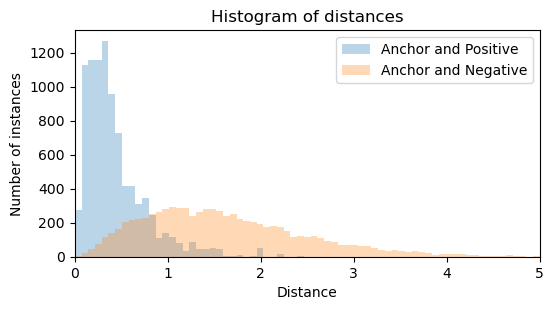

In [41]:
pos_dist = df_fairness[(df_fairness.y_true==1) & (df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)]['Distance']
neg_dist = df_fairness[(df_fairness.y_true==0) & (df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

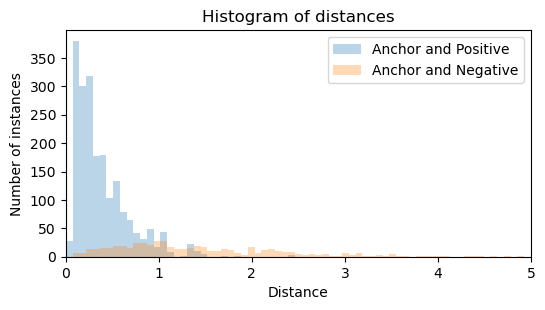

In [42]:
pos_dist = df_fairness[(df_fairness.y_true==1) & (df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)]['Distance']
neg_dist = df_fairness[(df_fairness.y_true==0) & (df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

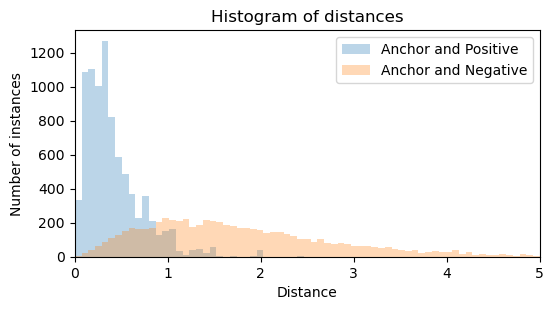

In [43]:
pos_dist = df_fairness[(df_fairness.y_true==1) & (df_fairness['A_White']==1)&(df_fairness['B_White']==1)]['Distance']
neg_dist = df_fairness[(df_fairness.y_true==0) & (df_fairness['A_White']==1)&(df_fairness['B_White']==1)]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

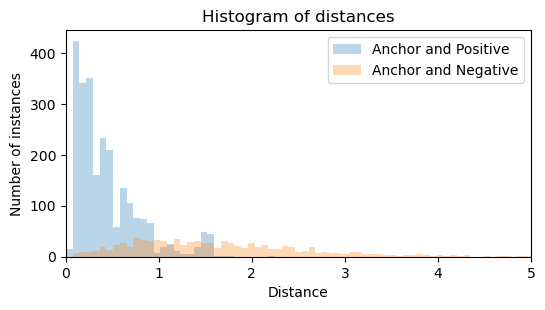

In [44]:
pos_dist = df_fairness[(df_fairness.y_true==1) & (df_fairness['A_White']==0)&(df_fairness['B_White']==0)]['Distance']
neg_dist = df_fairness[(df_fairness.y_true==0) & (df_fairness['A_White']==0)&(df_fairness['B_White']==0)]['Distance']
print_hist_dist_zoom(pos_dist, neg_dist, zoom=5.)

In [45]:
y_AB_Male = np.array(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)].y_true)
y_pred_AB_Male = np.array(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)].y_pred)

tn_AB_Male,fp_AB_Male,fn_AB_Male,tp_AB_Male = confusion_matrix(y_AB_Male, y_pred_AB_Male).ravel()

TPR_AB_Male = tp_AB_Male/(tp_AB_Male+fp_AB_Male)
FPR_AB_Male = fp_AB_Male/(tp_AB_Male+fp_AB_Male)
TNR_AB_Male = tn_AB_Male/(tn_AB_Male+fn_AB_Male)
FNR_AB_Male = fn_AB_Male/(tn_AB_Male+fn_AB_Male)

y_AB_NoMale = np.array(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)].y_true)
y_pred_AB_NoMale = np.array(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)].y_pred)

tn_AB_NoMale,fp_AB_NoMale,fn_AB_NoMale,tp_AB_NoMale = confusion_matrix(y_AB_NoMale, y_pred_AB_NoMale).ravel()

TPR_AB_NoMale = tp_AB_NoMale/(tp_AB_NoMale+fp_AB_NoMale)
FPR_AB_NoMale = fp_AB_NoMale/(tp_AB_NoMale+fp_AB_NoMale)
TNR_AB_NoMale = tn_AB_NoMale/(tn_AB_NoMale+fn_AB_NoMale)
FNR_AB_NoMale = fn_AB_NoMale/(tn_AB_NoMale+fn_AB_NoMale)

In [46]:
print("A and B Male - mean accuracy: ", df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)]['correct_predict'].mean())
print("A and B Male - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Male - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)]))
print("A and B Male - f1 score:", f1_score(y_AB_Male, y_pred_AB_Male))
print("A and B Male - Confusion Matrix")
print(confusion_matrix(y_AB_Male, y_pred_AB_Male))
print('A and B Male - TPR: ', TPR_AB_Male)
print('A and B Male - FPR: ', FPR_AB_Male)
print('A and B Male - TNR: ', TNR_AB_Male)
print('A and B Male - FNR: ', FNR_AB_Male)
print("\n")
print("A and B Non Male - mean accuracy: ", df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)]['correct_predict'].mean())
print("A and B Non Male - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Non Male - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)]))
print("A and B Non Male - f1 score:", f1_score(y_AB_NoMale, y_pred_AB_NoMale))
print("A and B Non Male - Confusion Matrix")
print(confusion_matrix(y_AB_NoMale, y_pred_AB_NoMale))
print('A and B Non Male - TPR: ', TPR_AB_NoMale)
print('A and B Non Male - FPR: ', FPR_AB_NoMale)
print('A and B Non Male - TNR: ', TNR_AB_NoMale)
print('A and B Non Male - FNR: ', FNR_AB_NoMale)

A and B Male - mean accuracy:  0.8554594531839554
A and B Male - bootstrapping mean accuracy:  [0.85122192 0.85365995 0.8554014  0.85720091 0.85975504]
A and B Male - triplet accuracy:  0.8917914779983745
A and B Male - f1 score: 0.870474406991261
A and B Male - Confusion Matrix
[[6370 1603]
 [ 887 8367]]
A and B Male - TPR:  0.8392176529588766
A and B Male - FPR:  0.16078234704112337
A and B Male - TNR:  0.8777731845115061
A and B Male - FNR:  0.12222681548849387


A and B Non Male - mean accuracy:  0.8700431880643895
A and B Non Male - bootstrapping mean accuracy:  [0.85904986 0.866117   0.87004319 0.87436199 0.88103651]
A and B Non Male - triplet accuracy:  0.6802827965435978
A and B Non Male - f1 score: 0.9170218099774379
A and B Non Male - Confusion Matrix
[[ 387  162]
 [ 169 1829]]
A and B Non Male - TPR:  0.9186338523355098
A and B Non Male - FPR:  0.08136614766449021
A and B Non Male - TNR:  0.6960431654676259
A and B Non Male - FNR:  0.3039568345323741


In [47]:
y_AB_White = np.array(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)].y_true)
y_pred_AB_White = np.array(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)].y_pred)

tn_AB_White,fp_AB_White,fn_AB_White,tp_AB_White = confusion_matrix(y_AB_White, y_pred_AB_White).ravel()

TPR_AB_White = tp_AB_White/(tp_AB_White+fp_AB_White)
FPR_AB_White = fp_AB_White/(tp_AB_White+fp_AB_White)
TNR_AB_White = tn_AB_White/(tn_AB_White+fn_AB_White)
FNR_AB_White = fn_AB_White/(tn_AB_White+fn_AB_White)

y_AB_NoWhite = np.array(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)].y_true)
y_pred_AB_NoWhite = np.array(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)].y_pred)

tn_AB_NoWhite,fp_AB_NoWhite,fn_AB_NoWhite,tp_AB_NoWhite = confusion_matrix(y_AB_NoWhite, y_pred_AB_NoWhite).ravel()

TPR_AB_NoWhite = tp_AB_NoWhite/(tp_AB_NoWhite+fp_AB_NoWhite)
FPR_AB_NoWhite = fp_AB_NoWhite/(tp_AB_NoWhite+fp_AB_NoWhite)
TNR_AB_NoWhite = tn_AB_NoWhite/(tn_AB_NoWhite+fn_AB_NoWhite)
FNR_AB_NoWhite = fn_AB_NoWhite/(tn_AB_NoWhite+fn_AB_NoWhite)

In [48]:
print("A and B White - mean accuracy: ", df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)]['correct_predict'].mean())
print("A and B White - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B White - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)]))
print("A and B White - f1 score:", f1_score(y_AB_White, y_pred_AB_White))
print("A and B White - Confusion Matrix")
print(confusion_matrix(y_AB_White, y_pred_AB_White))
print('A and B White - TPR: ', TPR_AB_White)
print('A and B White - FPR: ', FPR_AB_White)
print('A and B White - TNR: ', TNR_AB_White)
print('A and B White - FNR: ', FNR_AB_White)
print("\n")
print("A and B Non White - mean accuracy: ", df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)]['correct_predict'].mean())
print("A and B Non White - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Non White - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)]))
print("A and B Non White - f1 score:", f1_score(y_AB_NoWhite, y_pred_AB_NoWhite))
print("A and B Non White - Confusion Matrix")
print(confusion_matrix(y_AB_NoWhite, y_pred_AB_NoWhite))
print('A and B Non White - TPR: ', TPR_AB_NoWhite)
print('A and B Non White - FPR: ', FPR_AB_NoWhite)
print('A and B Non White - TNR: ', TNR_AB_NoWhite)
print('A and B Non White - FNR: ', FNR_AB_NoWhite)

A and B White - mean accuracy:  0.8712624038903858
A and B White - bootstrapping mean accuracy:  [0.86659657 0.86929092 0.87113097 0.87310245 0.87586252]
A and B White - triplet accuracy:  0.8813091482649842
A and B White - f1 score: 0.8886995057099029
A and B White - Confusion Matrix
[[5437 1215]
 [ 744 7821]]
A and B White - TPR:  0.8655378486055777
A and B White - FPR:  0.1344621513944223
A and B White - TNR:  0.8796311276492477
A and B White - FNR:  0.1203688723507523


A and B Non White - mean accuracy:  0.8638259833134684
A and B Non White - bootstrapping mean accuracy:  [0.85427592 0.85965435 0.86352801 0.86769964 0.87336114]
A and B Non White - triplet accuracy:  0.7300357568533969
A and B Non White - f1 score: 0.9052456976985279
A and B Non White - Confusion Matrix
[[ 716  196]
 [ 261 2183]]
A and B Non White - TPR:  0.9176124422026062
A and B Non White - FPR:  0.08238755779739386
A and B Non White - TNR:  0.7328556806550666
A and B Non White - FNR:  0.2671443193449335


### Other categories

#### Supposed races

In [49]:
y_AB_Black = np.array(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)].y_true)
y_pred_AB_Black = np.array(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)].y_pred)

tn_AB_Black,fp_AB_Black,fn_AB_Black,tp_AB_Black = confusion_matrix(y_AB_Black, y_pred_AB_Black).ravel()

TPR_AB_Black = tp_AB_Black/(tp_AB_Black+fp_AB_Black)
FPR_AB_Black = fp_AB_Black/(tp_AB_Black+fp_AB_Black)
TNR_AB_Black = tn_AB_Black/(tn_AB_Black+fn_AB_Black)
FNR_AB_Black = fn_AB_Black/(tn_AB_Black+fn_AB_Black)

y_AB_Asian = np.array(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)].y_true)
y_pred_AB_Asian = np.array(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)].y_pred)

tn_AB_Asian,fp_AB_Asian,fn_AB_Asian,tp_AB_Asian = confusion_matrix(y_AB_Asian, y_pred_AB_Asian).ravel()

TPR_AB_Asian = tp_AB_Asian/(tp_AB_Asian+fp_AB_Asian)
FPR_AB_Asian = fp_AB_Asian/(tp_AB_Asian+fp_AB_Asian)
TNR_AB_Asian = tn_AB_Asian/(tn_AB_Asian+fn_AB_Asian)
FNR_AB_Asian = fn_AB_Asian/(tn_AB_Asian+fn_AB_Asian)

y_AB_Indian = np.array(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)].y_true)
y_pred_AB_Indian = np.array(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)].y_pred)

tn_AB_Indian,fp_AB_Indian,fn_AB_Indian,tp_AB_Indian = confusion_matrix(y_AB_Indian, y_pred_AB_Indian).ravel()

TPR_AB_Indian = tp_AB_Indian/(tp_AB_Indian+fp_AB_Indian)
FPR_AB_Indian = fp_AB_Indian/(tp_AB_Indian+fp_AB_Indian)
TNR_AB_Indian = tn_AB_Indian/(tn_AB_Indian+fn_AB_Indian)
FNR_AB_Indian = fn_AB_Indian/(tn_AB_Indian+fn_AB_Indian)

In [50]:
print("A and B White - mean accuracy: ", df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)]['correct_predict'].mean())
print("A and B White - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B White - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)]))
print("A and B White - f1 score:", f1_score(y_AB_White, y_pred_AB_White))
print("A and B White - Confusion Matrix")
print(confusion_matrix(y_AB_White, y_pred_AB_White))
print('A and B White - TPR: ', TPR_AB_White)
print('A and B White - FPR: ', FPR_AB_White)
print('A and B White - TNR: ', TNR_AB_White)
print('A and B White - FNR: ', FNR_AB_White)
print("\n")
print("A and B Black - mean accuracy: ", df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)]['correct_predict'].mean())
print("A and B Black - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Black - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)]))
print("A and B Black - f1 score:", f1_score(y_AB_Black, y_pred_AB_Black))
print("A and B Black - Confusion Matrix")
print(confusion_matrix(y_AB_Black, y_pred_AB_Black))
print('A and B Black - TPR: ', TPR_AB_Black)
print('A and B Black - FPR: ', FPR_AB_Black)
print('A and B Black - TNR: ', TNR_AB_Black)
print('A and B Black - FNR: ', FNR_AB_Black)
print("\n")
print("A and B Asian - mean accuracy: ", df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)]['correct_predict'].mean())
print("A and B Asian - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Asian - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)]))
print("A and B Asian - f1 score:", f1_score(y_AB_Asian, y_pred_AB_Asian))
print("A and B Asian - Confusion Matrix")
print(confusion_matrix(y_AB_Asian, y_pred_AB_Asian))
print('A and B Asian - TPR: ', TPR_AB_Asian)
print('A and B Asian - FPR: ', FPR_AB_Asian)
print('A and B Asian - TNR: ', TNR_AB_Asian)
print('A and B Asian - FNR: ', FNR_AB_Asian)
print("\n")
print("A and B Indian - mean accuracy: ", df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)]['correct_predict'].mean())
print("A and B Indian - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Indian - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)]))
print("A and B Indian - f1 score:", f1_score(y_AB_Indian, y_pred_AB_Indian))
print("A and B Indian - Confusion Matrix")
print(confusion_matrix(y_AB_Indian, y_pred_AB_Indian))
print('A and B Indian - TPR: ', TPR_AB_Indian)
print('A and B Indian - FPR: ', FPR_AB_Indian)
print('A and B Indian - TNR: ', TNR_AB_Indian)
print('A and B Indian - FNR: ', FNR_AB_Indian)

A and B White - mean accuracy:  0.8712624038903858
A and B White - bootstrapping mean accuracy:  [0.86692186 0.86955379 0.87109811 0.8729053  0.87605967]
A and B White - triplet accuracy:  0.8813091482649842
A and B White - f1 score: 0.8886995057099029
A and B White - Confusion Matrix
[[5437 1215]
 [ 744 7821]]
A and B White - TPR:  0.8655378486055777
A and B White - FPR:  0.1344621513944223
A and B White - TNR:  0.8796311276492477
A and B White - FNR:  0.1203688723507523


A and B Black - mean accuracy:  0.8752293577981651
A and B Black - bootstrapping mean accuracy:  [0.85321101 0.86605505 0.87614679 0.88623853 0.89908257]
A and B Black - triplet accuracy:  0.5551470588235294
A and B Black - f1 score: 0.9294605809128631
A and B Black - Confusion Matrix
[[ 29  17]
 [ 51 448]]
A and B Black - TPR:  0.9634408602150538
A and B Black - FPR:  0.03655913978494624
A and B Black - TNR:  0.3625
A and B Black - FNR:  0.6375


A and B Asian - mean accuracy:  0.8601921024546425
A and B Asian - bo

#### Youth vs Senior

In [51]:
y_AB_Youth = np.array(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)].y_true)
y_pred_AB_Youth = np.array(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)].y_pred)

tn_AB_Youth,fp_AB_Youth,fn_AB_Youth,tp_AB_Youth = confusion_matrix(y_AB_Youth, y_pred_AB_Youth).ravel()

TPR_AB_Youth = tp_AB_Youth/(tp_AB_Youth+fp_AB_Youth)
FPR_AB_Youth = fp_AB_Youth/(tp_AB_Youth+fp_AB_Youth)
TNR_AB_Youth = tn_AB_Youth/(tn_AB_Youth+fn_AB_Youth)
FNR_AB_Youth = fn_AB_Youth/(tn_AB_Youth+fn_AB_Youth)

y_AB_Senior = np.array(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)].y_true)
y_pred_AB_Senior = np.array(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)].y_pred)

tn_AB_Senior,fp_AB_Senior,fn_AB_Senior,tp_AB_Senior = confusion_matrix(y_AB_Senior, y_pred_AB_Senior).ravel()

TPR_AB_Senior = tp_AB_Senior/(tp_AB_Senior+fp_AB_Senior)
FPR_AB_Senior = fp_AB_Senior/(tp_AB_Senior+fp_AB_Senior)
TNR_AB_Senior = tn_AB_Senior/(tn_AB_Senior+fn_AB_Senior)
FNR_AB_Senior = fn_AB_Senior/(tn_AB_Senior+fn_AB_Senior)

In [52]:
print("A and B Youth - mean accuracy: ", df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)]['correct_predict'].mean())
print("A and B Youth - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Youth - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)]))
print("A and B Youth - f1 score:", f1_score(y_AB_Youth, y_pred_AB_Youth))
print("A and B Youth - Confusion Matrix")
print(confusion_matrix(y_AB_Youth, y_pred_AB_Youth))
print('A and B Youth - TPR: ', TPR_AB_Youth)
print('A and B Youth - FPR: ', FPR_AB_Youth)
print('A and B Youth - TNR: ', TNR_AB_Youth)
print('A and B Youth - FNR: ', FNR_AB_Youth)
print("\n")
print("A and B Senior - mean accuracy: ", df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)]['correct_predict'].mean())
print("A and B Senior - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)], agg_func=lambda df: df['correct_predict'].mean()))
print("A and B Senior - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)]))
print("A and B Senior - f1 score:", f1_score(y_AB_Senior, y_pred_AB_Senior))
print("A and B Senior - Confusion Matrix")
print(confusion_matrix(y_AB_Senior, y_pred_AB_Senior))
print('A and B Senior - TPR: ', TPR_AB_Senior)
print('A and B Senior - FPR: ', FPR_AB_Senior)
print('A and B Senior - TNR: ', TNR_AB_Senior)
print('A and B Senior - FNR: ', FNR_AB_Senior)

A and B Youth - mean accuracy:  0.8708955223880597
A and B Youth - bootstrapping mean accuracy:  [0.85522388 0.8641791  0.87089552 0.87630597 0.8858209 ]
A and B Youth - triplet accuracy:  0.6761194029850747
A and B Youth - f1 score: 0.9167869167869168
A and B Youth - Confusion Matrix
[[214  69]
 [104 953]]
A and B Youth - TPR:  0.9324853228962818
A and B Youth - FPR:  0.0675146771037182
A and B Youth - TNR:  0.6729559748427673
A and B Youth - FNR:  0.3270440251572327


A and B Senior - mean accuracy:  0.9174972314507198
A and B Senior - bootstrapping mean accuracy:  [0.90694906 0.91362126 0.91860465 0.92248062 0.92857143]
A and B Senior - triplet accuracy:  0.7264673311184939
A and B Senior - f1 score: 0.9456402772710689
A and B Senior - Confusion Matrix
[[ 361  110]
 [  39 1296]]
A and B Senior - TPR:  0.9217638691322901
A and B Senior - FPR:  0.07823613086770982
A and B Senior - TNR:  0.9025
A and B Senior - FNR:  0.0975


#### Accessories

In [53]:
y_AB_Sunglasses = np.array(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)].y_true)
y_pred_AB_Sunglasses = np.array(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)].y_pred)

tn_AB_Sunglasses,fp_AB_Sunglasses,fn_AB_Sunglasses,tp_AB_Sunglasses = confusion_matrix(y_AB_Sunglasses, y_pred_AB_Sunglasses).ravel()

TPR_AB_Sunglasses = tp_AB_Sunglasses/(tp_AB_Sunglasses+fp_AB_Sunglasses)
FPR_AB_Sunglasses = fp_AB_Sunglasses/(tp_AB_Sunglasses+fp_AB_Sunglasses)
TNR_AB_Sunglasses = tn_AB_Sunglasses/(tn_AB_Sunglasses+fn_AB_Sunglasses)
FNR_AB_Sunglasses = fn_AB_Sunglasses/(tn_AB_Sunglasses+fn_AB_Sunglasses)

y_AB_NoSunglasses = np.array(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)].y_true)
y_pred_AB_NoSunglasses = np.array(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)].y_pred)

tn_AB_NoSunglasses,fp_AB_NoSunglasses,fn_AB_NoSunglasses,tp_AB_NoSunglasses = confusion_matrix(y_AB_NoSunglasses, y_pred_AB_NoSunglasses).ravel()

TPR_AB_NoSunglasses = tp_AB_NoSunglasses/(tp_AB_NoSunglasses+fp_AB_NoSunglasses)
FPR_AB_NoSunglasses = fp_AB_NoSunglasses/(tp_AB_NoSunglasses+fp_AB_NoSunglasses)
TNR_AB_NoSunglasses = tn_AB_NoSunglasses/(tn_AB_NoSunglasses+fn_AB_NoSunglasses)
FNR_AB_NoSunglasses = fn_AB_NoSunglasses/(tn_AB_NoSunglasses+fn_AB_NoSunglasses)

In [54]:
print("A and B Sunglasses - mean accuracy: ", df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)]['correct_predict'].mean())
print("A and B Sunglasses - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)], agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000))
print("A and B Sunglasses - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)]))
print("A and B Sunglasses - f1 score:", f1_score(y_AB_Sunglasses, y_pred_AB_Sunglasses))
print("A and B Sunglasses - Confusion Matrix")
print(confusion_matrix(y_AB_Sunglasses, y_pred_AB_Sunglasses))
print('A and B Sunglasses - TPR: ', TPR_AB_Sunglasses)
print('A and B Sunglasses - FPR: ', FPR_AB_Sunglasses)
print('A and B Sunglasses - TNR: ', TNR_AB_Sunglasses)
print('A and B Sunglasses - FNR: ', FNR_AB_Sunglasses)
print("\n")
print("A and B Non Sunglasses - mean accuracy: ", df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)]['correct_predict'].mean())
print("A and B Non Sunglasses - bootstrapping mean accuracy: ", bootstrap(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)], agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000))
print("A and B Non Sunglasses - triplet accuracy: ", triplet_acc_fairness(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)]))
print("A and B Non Sunglasses - f1 score:", f1_score(y_AB_NoSunglasses, y_pred_AB_NoSunglasses))
print("A and B Non Sunglasses - Confusion Matrix")
print(confusion_matrix(y_AB_NoSunglasses, y_pred_AB_NoSunglasses))
print('A and B Non Sunglasses - TPR: ', TPR_AB_NoSunglasses)
print('A and B Non Sunglasses - FPR: ', FPR_AB_NoSunglasses)
print('A and B Non Sunglasses - TNR: ', TNR_AB_NoSunglasses)
print('A and B Non Sunglasses - FNR: ', FNR_AB_NoSunglasses)

A and B Sunglasses - mean accuracy:  0.5813953488372093
A and B Sunglasses - bootstrapping mean accuracy:  [0.46511628 0.53488372 0.58139535 0.62790698 0.69767442]
A and B Sunglasses - triplet accuracy:  0.42857142857142855
A and B Sunglasses - f1 score: 0.7096774193548387
A and B Sunglasses - Confusion Matrix
[[ 3  0]
 [18 22]]
A and B Sunglasses - TPR:  1.0
A and B Sunglasses - FPR:  0.0
A and B Sunglasses - TNR:  0.14285714285714285
A and B Sunglasses - FNR:  0.8571428571428571


A and B Non Sunglasses - mean accuracy:  0.8683716756403981
A and B Non Sunglasses - bootstrapping mean accuracy:  [0.86478218 0.86686246 0.86837168 0.8698401  0.87196117]
A and B Non Sunglasses - triplet accuracy:  0.9369391417849567
A and B Non Sunglasses - f1 score: 0.8728876984283295
A and B Non Sunglasses - Confusion Matrix
[[10209  2016]
 [ 1211 11080]]
A and B Non Sunglasses - TPR:  0.8460598656078192
A and B Non Sunglasses - FPR:  0.15394013439218082
A and B Non Sunglasses - TNR:  0.8939579684763572

#### More bootstrapping

In [55]:
b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_WhiteMale']==1], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]), 3)

print(f"A and B White Male - accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap_by_pairs(df_fairness[df_fairness['AB_WhiteMale']==1], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3)

print(f"A and B White Male - triplet accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_WhiteMale']==1], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B White Male - FPR: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_WhiteMale']==1], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B White Male - FNR: {a} (90% CI: {b}-{c})")

print("\n")

b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_NoWhiteMale']==1], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non White Male - accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap_by_pairs(df_fairness[df_fairness['AB_NoWhiteMale']==1], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3)

print(f"A and B Non White Male - triplet accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_NoWhiteMale']==1], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)
 
print(f"A and B Non White Male - FPR: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[df_fairness['AB_NoWhiteMale']==1], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non White Male - FNR: {a} (90% CI: {b}-{c})")

A and B White Male - accuracy: 0.86 (90% CI: 0.855-0.866)
A and B White Male - triplet accuracy: 0.84 (90% CI: 0.832-0.85)
A and B White Male - FPR: 0.142 (90% CI: 0.136-0.149)
A and B White Male - FNR: 0.135 (90% CI: 0.126-0.144)


A and B Non White Male - accuracy: 0.866 (90% CI: 0.858-0.873)
A and B Non White Male - triplet accuracy: 0.794 (90% CI: 0.778-0.81)
A and B Non White Male - FPR: 0.096 (90% CI: 0.089-0.104)
A and B Non White Male - FNR: 0.204 (90% CI: 0.19-0.219)


In [56]:
b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]), 3)

print(f"A and B Male - accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3)

print(f"A and B Male - triplet accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Male - FPR: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==1)&(df_fairness['B_Male']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Male - FNR: {a} (90% CI: {b}-{c})")

print("\n")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non Male - accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3)

print(f"A and B Non Male - triplet accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non Male - FPR: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_Male']==0)&(df_fairness['B_Male']==0)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non Male - FNR: {a} (90% CI: {b}-{c})")

A and B Male - accuracy: 0.855 (90% CI: 0.851-0.86)
A and B Male - triplet accuracy: 0.892 (90% CI: 0.888-0.896)
A and B Male - FPR: 0.161 (90% CI: 0.155-0.167)
A and B Male - FNR: 0.122 (90% CI: 0.116-0.129)


A and B Non Male - accuracy: 0.87 (90% CI: 0.859-0.881)
A and B Non Male - triplet accuracy: 0.678 (90% CI: 0.64-0.719)
A and B Non Male - FPR: 0.081 (90% CI: 0.071-0.091)
A and B Non Male - FNR: 0.304 (90% CI: 0.271-0.336)


In [57]:
b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]), 3)

print(f"A and B White - accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3)

print(f"A and B White - triplet accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B White - FPR: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B White - FNR: {a} (90% CI: {b}-{c})")

print("\n")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non White - accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3)

print(f"A and B Non White - triplet accuracy: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non White - FPR: {a} (90% CI: {b}-{c})")

b,a,c = np.round_(bootstrap(df_fairness[(df_fairness['A_White']==0)&(df_fairness['B_White']==0)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3)

print(f"A and B Non White - FNR: {a} (90% CI: {b}-{c})")

A and B White - accuracy: 0.871 (90% CI: 0.867-0.876)
A and B White - triplet accuracy: 0.881 (90% CI: 0.876-0.887)
A and B White - FPR: 0.134 (90% CI: 0.129-0.14)
A and B White - FNR: 0.12 (90% CI: 0.114-0.127)


A and B Non White - accuracy: 0.864 (90% CI: 0.854-0.873)
A and B Non White - triplet accuracy: 0.723 (90% CI: 0.692-0.76)
A and B Non White - FPR: 0.082 (90% CI: 0.073-0.092)
A and B Non White - FNR: 0.267 (90% CI: 0.244-0.291)


In [58]:
print("A and B White - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]), 3))
print("A and B White - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B White - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B White - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_White']==1)&(df_fairness['B_White']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("\n")
print("A and B Black - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Black - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B Black - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Black - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Black']==1)&(df_fairness['B_Black']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("\n")
print("A and B Asian - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]), 3))
print("A and B Asian - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B Asian - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Asian - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Asian']==1)&(df_fairness['B_Asian']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("\n")
print("A and B Indian - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Indian - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B Indian - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Indian - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Indian']==1)&(df_fairness['B_Indian']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))

A and B White - mean accuracy:  [0.867 0.871 0.876]
A and B White - triplet accuracy:  [0.875 0.881 0.887]
A and B White - FPR:  [0.129 0.134 0.14 ]
A and B White - FNR:  [0.114 0.12  0.127]


A and B Black - mean accuracy:  [0.851 0.875 0.897]
A and B Black - triplet accuracy:  [0.272 0.5   0.8  ]
A and B Black - FPR:  [0.023 0.036 0.051]
A and B Black - FNR:  [0.548 0.638 0.724]


A and B Asian - mean accuracy:  [0.841 0.86  0.878]
A and B Asian - triplet accuracy:  [0.457 0.576 0.667]
A and B Asian - FPR:  [0.033 0.044 0.057]
A and B Asian - FNR:  [0.497 0.56  0.622]


A and B Indian - mean accuracy:  [0.953 0.984 1.   ]
A and B Indian - triplet accuracy:  [0. 0. 0.]
A and B Indian - FPR:  [0.    0.016 0.049]


/tmp/ipykernel_8142/2428058568.py:42: RuntimeWarning: invalid value encountered in long_scalars
  agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \


A and B Indian - FNR:  [nan nan nan]


In [59]:
print("A and B Youth - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]), 3))
print("A and B Youth - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B Youth - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Youth - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Youth']==1)&(df_fairness['B_Youth']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("\n")
print("A and B Senior - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Senior - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B Senior - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Senior - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Senior']==1)&(df_fairness['B_Senior']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))

A and B Youth - mean accuracy:  [0.856 0.871 0.886]
A and B Youth - triplet accuracy:  [0.608 0.682 0.766]
A and B Youth - FPR:  [0.055 0.067 0.081]
A and B Youth - FNR:  [0.285 0.327 0.372]


A and B Senior - mean accuracy:  [0.907 0.917 0.928]
A and B Senior - triplet accuracy:  [0.645 0.716 0.795]
A and B Senior - FPR:  [0.067 0.078 0.09 ]
A and B Senior - FNR:  [0.074 0.097 0.123]


In [64]:
print("A and B Sunglasses - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]), 3))
print("A and B Sunglasses - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B Sunglasses - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Sunglasses - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Sunglasses']==1)&(df_fairness['B_Sunglasses']==1)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("\n")
print("A and B Non Sunglasses - mean accuracy: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)], \
    agg_func=lambda df: df['correct_predict'].mean(), num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Non Sunglasses - triplet accuracy: ", np.round_(bootstrap_by_pairs(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)], \
    agg_func=lambda df: triplet_acc_fairness(df), num_bootstraps=100, percentiles=[5,50,95]), 3))
print("A and B Non Sunglasses - FPR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)], \
    agg_func=lambda df: df[(df['y_pred']==1)&(df['y_true']==0)]['id_A'].count()/df[df['y_pred']==1]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))
print("A and B Non Sunglasses - FNR: ", np.round_(bootstrap(df_fairness[(df_fairness['A_Sunglasses']==0)&(df_fairness['B_Sunglasses']==0)], \
    agg_func=lambda df: df[(df['y_pred']==0)&(df['y_true']==1)]['id_A'].count()/df[df['y_pred']==0]['id_A'].count(), \
    num_bootstraps=10000, percentiles=[5,50,95]),3))

A and B Sunglasses - mean accuracy:  [0.465 0.581 0.698]
A and B Sunglasses - triplet accuracy:  [0. 0. 0.]
A and B Sunglasses - FPR:  [0. 0. 0.]
A and B Sunglasses - FNR:  [0.722 0.864 0.96 ]


A and B Non Sunglasses - mean accuracy:  [0.854 0.858 0.861]
A and B Non Sunglasses - triplet accuracy:  [0.926 0.929 0.932]
A and B Non Sunglasses - FPR:  [0.169 0.175 0.18 ]
A and B Non Sunglasses - FNR:  [0.098 0.103 0.107]
